# Import Azure ML Python SDK

In [ ]:
import azureml.core
import pandas as pd
import numpy as np
from azureml.train.automl.run import AutoMLRun
from azureml.core import Workspace, Experiment, Dataset
from azureml.core.compute import AmlCompute, ComputeTarget

# Connect to workspace

In [ ]:
ws = Workspace.get(
    name="ml-ws-11", subscription_id='e0e48bbb-9992-4be9-aebf-1bc546c865a3', resource_group='CV_Res_Gr')

# Create an experiment instance

In [ ]:
experiment_name="experiment-1-voting-ensembler"
experiment=Experiment(ws, experiment_name)

# Connect to the compute cluster

In [ ]:

amlcompute_cluster_name="telco-ml-compute"
cts=ws.compute_targets
compute_target=cts[amlcompute_cluster_name]

# Get the most recent run info

In [ ]:

run_id='AutoML_da6fdf74-6c3b-4398-bb16-bbbc86c8021b'
training_run=AutoMLRun(experiment, run_id)
training_run

# Get details of the run

In [ ]:
training_run.get_details()

# Get the best fitted model info

In [ ]:
best_run,fitted_model=training_run.get_output()

In [ ]:
# conda install -c anaconda azureml-train-automl-runtime==1.19.0  
# conda install -c conda-forge azureml-train-automl-runtime==1.19.0  

In [ ]:
best_run

In [ ]:
model_name=best_run.properties['model_name']
model_name

## Save the executive file into the repo 

In [ ]:
script_file_name='inference/score.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

# Register the model

In [ ]:
# Register the model
description ="telecom customer churn best model"
model=training_run.register_model(model_name=model_name, description=description, tags=None)
print(training_run.model_id)

# Deploy the model and create a web service

In [ ]:
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.environment import Environment

# Define what script to run, which environment to use
inference_config=InferenceConfig(entry_script=script_file_name, environment=best_run.get_environment())

# Define the deployment configuration for Azure Container Instance(ACI)
aciconfig=AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1, tags={'type':'automl-churnpredictor'}, description='Sample service for customer churn prediction')

# Deploy the model as a Web Service
aci_service_name="customer-churn-detection-ser"
print(aci_service_name)
aci_service=Model.deploy(ws,aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

# Test the model
## Get the test data and drop the churn column

In [ ]:
#Test data includes 39 rows of customer data
test_df=pd.read_csv('NewData-Telco-Customer-Retention.csv')
test_df_woc=test_df.drop('Churn',axis=1)

test_df_woc.head()

# Make an API call to the deployed model with sending the test data

In [ ]:
import json
# test_df_woc is the dataset without 'Churn' column
# We need to transform it into json format
test_sample=json.dumps({'data':test_df_woc.to_dict(orient='records')})
# Call the Web Service
response=aci_service.run(input_data=test_sample)
response

In [ ]:
# first json to dictionary
res_dict=json.loads(response)
# then result dictionary to pandas dataframe
predicted_all=pd.DataFrame(res_dict['result'])
predicted_all['Predicted']=res_dict['result']

## Display the response (as actual and predicted columns side by side )

In [8]:
# Display side by side the truth and predicted response from API
webservice_df=pd.DataFrame({'Actual': test_df['Churn'], 'Predicted':predicted_all['Predicted']})
webservice_df

NameError: name 'pd' is not defined

## Analyze the accuracy level

In [ ]:
counter=0
for index, row in webservice_df.iterrows():
    if row['Actual']=='Yes' and row['Predicted']==True or row['Actual']=='No' and row['Predicted']==False:
        print(row['Actual'], row['Predicted'], True)
    else:
        print(row['Actual'], row['Predicted'],'-----',index, '-----')
        counter+=1

In [ ]:
p1='is likely to churn. You had better take some action!'
p2='is happy and loyal. No need to take extra precautions.'
counter

# Illustrate the accuracy percentage using plots:

In [5]:
import matplotlib.pyplot as plt

value_SenCit = counter/ len(webservice_df) * 100 # 7.7

# Pie chart:
label_Truth = ['False Prediction', 'True Prediction']
sizes = [value_SenCit, 100-value_SenCit]
explode = (0, 0.1)  # only "explode" the 2nd slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=label_Truth, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Accuracy Rate', loc='center', pad = 100, fontdict={'fontsize':18})

plt.show()

NameError: name 'counter' is not defined

In [ ]:
# def check_type(v):
#     if isinstance(v, np.integer):
#         v=int(v)
#     elif isinstance(v, np.floating):
#         v=float(v)
    # elif isinstance(v, np.ndarray):
    #     v=v.tolist()

# Sample implementation of making a call with user-filled form submission and getting the prediction response from the API. 

In [ ]:
%matplotlib widget
import ipywidgets as widgets

In [7]:
def get_val(k,v):
    print(f'Selected value is {v}')
    # check_type(v)
    if isinstance(v, np.integer):
        v=int(v)
    elif isinstance(v, np.floating):
        v=float(v)
    new_cust_data[k]=v

new_cust_data={}
for k in test_df.columns[:-1]:
    if k=='customerID':
        k=widgets.interact(get_val, k=k, v='')
    else:
        widgets.interact(get_val, k=k,v=sorted(test_df[k].unique()))

NameError: name 'test_df' is not defined

In [ ]:
new_cust_data

## Make the call, get the response

In [ ]:
import requests

url = "http://1ec974d4-f3fc-4716-a25e-ff123f981a78.westeurope.azurecontainer.io/score"

payload={"data":[new_cust_data]}
headers = {
  'operationId': 'RunMLService',
  'Content-Type': 'application/json'
}
#API call to model
response = requests.post(url, headers=headers, json=payload)

print(response.text)

# Show the response

In [ ]:
out = widgets.Output(layout={'border': '1px solid black', 'height':'100px'})


In [ ]:
with out:
    parsed_json = json.loads(response.text)[12:-2]
    if parsed_json=="true":
        print(f"{new_cust_data['customerID']} {p1}")
    elif parsed_json=="false":
        print(f"{new_cust_data['customerID']} {p2}")

In [ ]:
out

In [2]:
# Utils widgets
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, TwoByTwoLayout
from data_dict import findings
def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

top_left_button = create_expanded_button(findings['a'], 'danger')
top_right_button = create_expanded_button(findings['b'], 'success')
bottom_left_button = create_expanded_button(findings['c'], 'info')
bottom_right_button = create_expanded_button(findings['d'], 'warning')

# Our Findings and Considerations

In [3]:
TwoByTwoLayout(top_left=top_left_button,
               top_right=top_right_button,
               bottom_left=bottom_left_button,
               bottom_right=bottom_right_button,
               height="200px")

TwoByTwoLayout(children=(Button(button_style='info', description='AutoML and high-code model trials return alm…

# One-pager

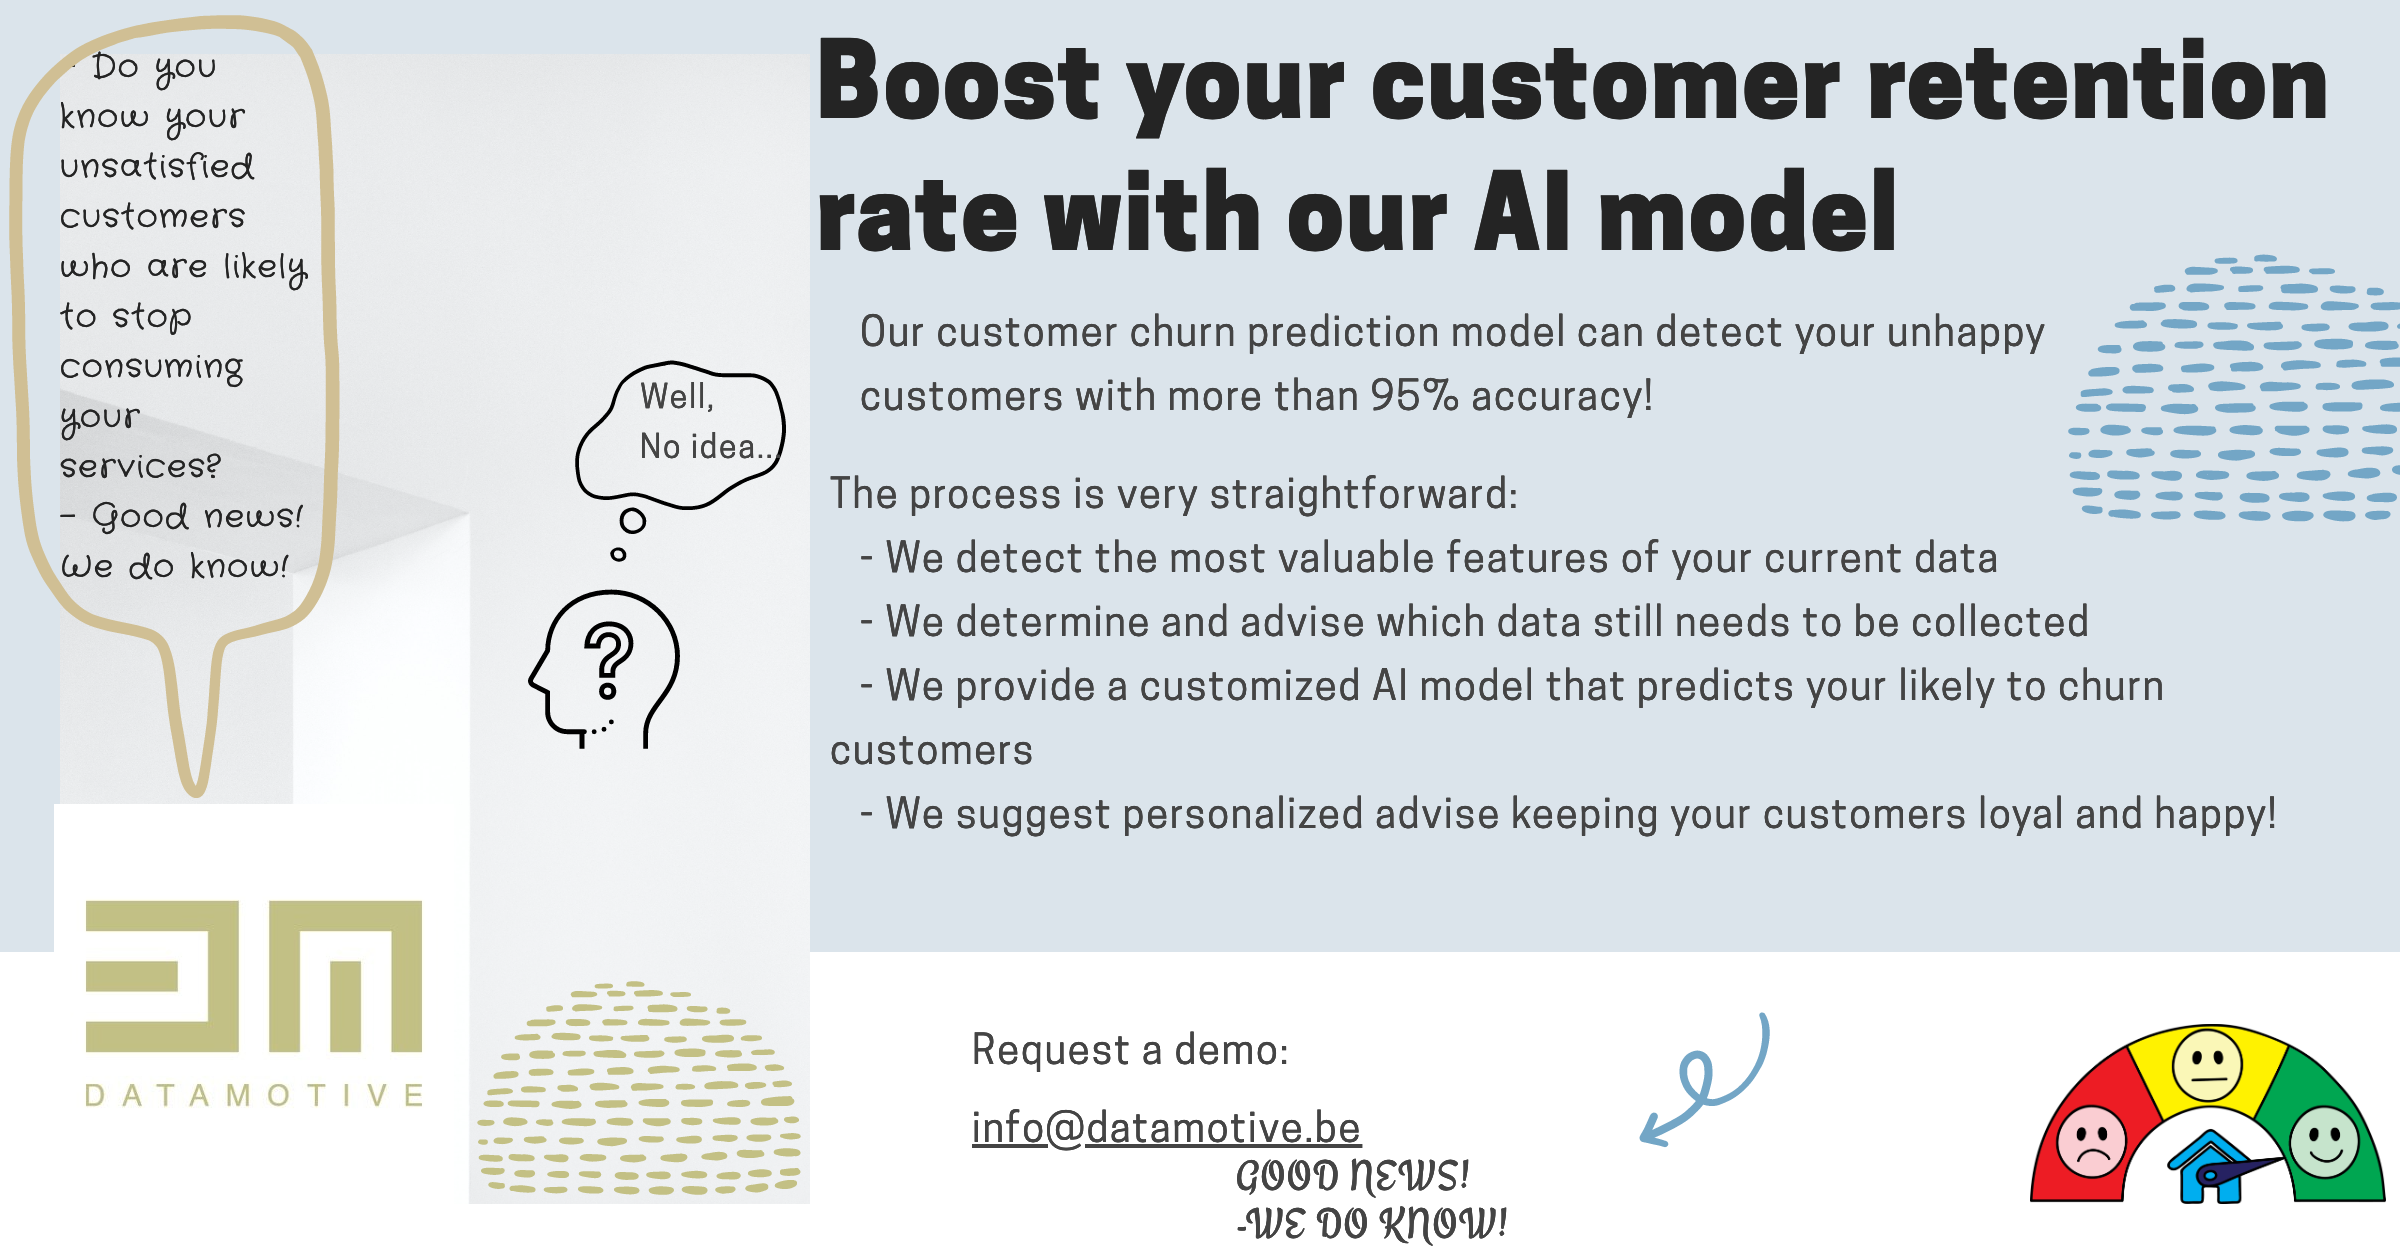

In [176]:
from IPython.display import Image
Image(filename='one_pager.png') 